# **Visualizing web scraped music festival data in Tableau** 

*By Ryan Moore*

## Project Overview and Objectives

#### *Overview*

The following is a personal project where publicly available tables containing music festival data are web scraped, combined, cleaned, and visualized in Tableau.

#### *Objectives*

This project will have five main objectives:

1. Web scrape music festival data from Festival Alarm, a publicly available website that tracks music festival data (mainly in Europe)
2. Combine the scraped data into a single table
3. Perform a high-level analysis of the data and clean it as needed
4. Export the data to Tableau and create visualizations for publication
5. Document findings and analysis in a blog post

#### *A note on web scraping*

The Flatiron school data science boot camp teaches it's students to always check the terms and conditions of a website before web scraping. Festival Alarm does not have a terms and conditions page, but it does have a privacy policy page (however, it is in German, so this was translated using Google Translate).

The privacy policy page does not explicitly state that web scraping is not allowed, but it does state that the website is not to be used for commercial purposes.I reached out to the website owners and waited a week for their response; none was given. Since this project is for educational purposes only and there is no explicit statement against web scraping, I decided to proceed with the project.

If anyone from Festival Alarm reads this and would like me to take down this project, please reach out to me and I will do so immediately. You can email me at mooreaz92@gmail.com or message me on GitHub.

## Objective 1: Web scrape the music festival data

**Website Overview**

The target website looks like this:

<div style="text-align: center;">
  <img src="/home/mooreaz92/Personal_Projects/music_festival_viz_practice/images/website_screen_1.png" alt="Website Screen 1" width="50%" style="border-radius: 10px;">
</div>

The above example is for the year of 2023. In order to change years, you must click on the year in the top right corner of the screen. This will bring you to a page that looks like this:

<div style="text-align: center;">
  <img src="/home/mooreaz92/Personal_Projects/music_festival_viz_practice/images/website_screen_2.png" alt="Website Screen 2" width="30%" style="border-radius: 10px;">
</div>

From here, you can click on the year you want to view and a table like the first screenshot will pop up. The table contains the following fields (I have added what I believe each field to mean in italics):

- Name 
  - *The name of the festival*
- Date + [year being viewed] 
  - *The date of the festival*
- Duration 
  - *The duration, in days, of the festival*
- Where 
  - *Whether the festival is indoors or outdoors*
- Category 
  - *The type of music played at the festival*
- Genres 
  - *The genres of music played at the festival*
- Country 
  - *The country the festival is located in*
- Visitors 
  - *The number of visitors the festival had*
- Price 
  - *The price of a ticket to the festival, in euros*
- Links 
  - *Links to the festival's website, ticket site, and an option to add to your festival list*




**Webscraping Strategy**

To webscrape this data, I will use a combination of the `requests` and `BeautifulSoup` libraries. The `requests` library will be used to make the HTTP request to the website and the `BeautifulSoup` library will be used to parse the HTML and extract the data. High level, we will code a custom function that takes in a list of years and that does the following:

1. Makes an HTTP request to the website
2. Parses the HTML using `BeautifulSoup`
3. Extracts the data from the HTML
4. Returns the data in a list of dictionaries
5. Combines the list of dictionaries into a single dataframe

In [1]:
### Importing libraries

import requests
import csv
import pandas as pd
from bs4 import BeautifulSoup

### Doing a sample request to the website, and checking if the request was successful

url = 'https://www.festival-alarm.com/us/Festivals-2023'
response = requests.get(url)
assert response.status_code == 200

**Beautiful Soup Analysis**

Before we can write the webscraping function it would be good if we could get a better understanding of the HTML structure of the website. To do this, we will use the `BeautifulSoup` library to parse the HTML and then use the `prettify()` method to print out the HTML in a more readable format.

In [2]:
### Making a request to the website, and getting the HTML content

url = 'https://www.festival-alarm.com/us/Festivals-2023'
response = requests.get(url)
html = response.content
soup = BeautifulSoup(html, "html.parser")

### Using prettify to make the HTML content more readable, and identifying the html elements that make up the table. (Commented out)

# print(soup.prettify())

After taking a look at the prettified text dump in a seperate text editor, it looks like this table uses the **table**, **tr**, and **td** html table elements. We can use this information when we code the webscraping function.

We can use beautiful soup to pull the table element, and then use the .read_html pandas method to convert the table into a dataframe. This will be useful when we are testing our webscraping function.

In [3]:
### Parsing the HTML content using BeautifulSoup and converting it to a dataframe
table = soup.find('table')

### Converting the HTML table to a dataframe
df = pd.read_html(str(table))[0]

### Printing the info of the dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 743 entries, 0 to 742
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         743 non-null    object 
 1   Date 2023    743 non-null    object 
 2   Duration     743 non-null    object 
 3   Where        743 non-null    object 
 4   Category     743 non-null    object 
 5   Genres       743 non-null    object 
 6   Country      743 non-null    object 
 7   Venue        743 non-null    object 
 8   Visitors     743 non-null    object 
 9   Price(s.f.)  473 non-null    object 
 10  Unnamed: 10  0 non-null      float64
dtypes: float64(1), object(10)
memory usage: 64.0+ KB


**Checking the sample webscraping method is pulling everything from the site**

Luckily for us, the website has content at the end of the table which shows a count of records. We can use this to check that our webscraping function is pulling all of the data from the website.

<div style="text-align: center;">
  <img src="/home/mooreaz92/Personal_Projects/music_festival_viz_practice/images/website_screen_3.png" alt="Website Screen 3" width="30%" style="border-radius: 10px;">
</div>

Looks like our webscraping function is pulling all of the data from the sample website page. Now we can move on to coding the webscraping function to bring in a bunch of years at once.

## Objective 2: Combine the scraped data into a single table

**Coding the webscraping function**

Now that we have a webscraping function that works for a single year, we can code a function that will pull in multiple years at once. 

The function will take in a range of years and will return a dataframe with all of the data from the years in the range. It would be useful to have the year be a column in the dataframe for each row since it currently only exists in the table header. We can do this by adding a column to the dataframe and filling it with the year that the data was pulled from. 

In [4]:
### Making a function that requests the HTML content of each url in range of years, appends the year, and then appends each together into a single dataframe

def get_festival_data(start_year, end_year):
    df_list = []
    for year in range(start_year, end_year + 1):
        url = f'https://www.festival-alarm.com/us/Festivals-{year}'
        response = requests.get(url)
        html = response.content
        soup = BeautifulSoup(html, "html.parser")
        table = soup.find('table')
        df = pd.read_html(str(table))[0]
        df['year'] = year
        df_list.append(df)
    return pd.concat(df_list, ignore_index=True)

**Performing the final extract of the data**

Now that we have a webscraping function that works for multiple years, we can use it to extract the data from the website. We will extract all the available data from the website, which is from 2014 to 2024 (future dates for upcoming festivals). We will perform high level checks on the data in the next section.

In [5]:
### Getting the data for the years 2014 to 2024

df = get_festival_data(2014, 2024)

## Objective 3: Perform a high-level analysis of the data and clean it as needed

With the data extracted, we can now perform a high-level analysis of the data and clean it as needed. 

**Fixing the date column**

From looking at the .info() of the dataframe, we can tell that the date range of the festival is in unique columns depending on the year the festival took place.

For example, if a festival took place between July 14th, 2015 and July 18th, 2015, the row would be populated with 07/14-07/18 in the Date 2015 column and all other 'Date' columns would be blank. It would be better if we had a start_date and end_date column instead of a column for each year. We can do this by creating a function that takes in a row and returns the start and end date of the festival.

In [6]:
### Making a function that extracts the date range

def extract_date_range(row):
    year = row['year']
    date_columns = [col for col in row.index if col.startswith('Date')]
    date_column = next((col for col in date_columns if str(year) in col), None)
    
    if date_column:
        date_range = row[date_column]
        start_date = date_range[:5] + "/" + str(year)
        end_date = date_range[-5:] + "/" + str(year)
        return start_date, end_date
    
    return None, None

### Applying the function to the dataframe

df_date = df.copy()
df_date['start_date'], df_date['end_date'] = zip(*df_date.apply(extract_date_range, axis=1))

### Dropping the 'Date' columns with the exception of the newly created start_date and end_date columns

df_date_cleaned = df_date.drop(columns=[col for col in df_date.columns if col.startswith('Date') and col not in ['start_date', 'end_date']])

**Investigating Nulls**

We should also check for nulls in the dataframe. There is one column that contains only null values; this is likely a column that was added to the website after the data was scraped. We can drop this column.

The remaining data looks good, so we can move on to the next step and create some visualizations to get a high level sense of the data and make sure it makes sense before exporting to Tableau.

In [7]:
### Dropping the columns that only contain NaN values

df_date_cleaned = df_date_cleaned.dropna(axis=1, how='all')

**Extracting the numerical value in duration and Price**

The duration column contains the number of days that the festival lasted and the price contains the price of a ticket to the festival in Euros. We can extract the numerical value from these columns and create new columns for them.

In [8]:
df_date_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2829 entries, 0 to 2828
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         2829 non-null   object
 1   Duration     2829 non-null   object
 2   Where        2829 non-null   object
 3   Category     2829 non-null   object
 4   Genres       2829 non-null   object
 5   Country      2829 non-null   object
 6   Venue        2829 non-null   object
 7   Visitors     2829 non-null   object
 8   Price(s.f.)  2015 non-null   object
 9   year         2829 non-null   int64 
 10  start_date   2829 non-null   object
 11  end_date     2829 non-null   object
dtypes: int64(1), object(11)
memory usage: 265.3+ KB


In [9]:
### Extracting the numerical value from the 'duration' column

df_date_cleaned['Duration'] = df_date_cleaned['Duration'].str.extract('(\d+)').astype(int)

### Renaming the 'Duration' column to 'Duration (days)'

df_date_cleaned = df_date_cleaned.rename(columns={'Duration': 'Duration (days)'})

### Extracting the numerical value from the 'Price' column and putting 0 for NaN values

df_date_cleaned['Price(s.f.)'] = df_date_cleaned['Price(s.f.)'].str.extract('(\d+)').fillna(0).astype(int)

### Renaming the 'Price' column to 'Price (EUR)'

df_date_cleaned = df_date_cleaned.rename(columns={'Price(s.f.)': 'Ticket Price (EUR)'})

In [10]:
df_date_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2829 entries, 0 to 2828
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Name                2829 non-null   object
 1   Duration (days)     2829 non-null   int64 
 2   Where               2829 non-null   object
 3   Category            2829 non-null   object
 4   Genres              2829 non-null   object
 5   Country             2829 non-null   object
 6   Venue               2829 non-null   object
 7   Visitors            2829 non-null   object
 8   Ticket Price (EUR)  2829 non-null   int64 
 9   year                2829 non-null   int64 
 10  start_date          2829 non-null   object
 11  end_date            2829 non-null   object
dtypes: int64(3), object(9)
memory usage: 265.3+ KB


**One-hot-encoding the genres column**

The genres column contains a list of genres for each festival. We can one-hot-encode this column to make it easier to work with in Tableau, but it is worth investigating the number of unique genres in the column first. If there are too many unique genres, it may not be worth one-hot-encoding the column.

In [11]:
### Investigating the unique values in each list contained in the 'Genre' column

genre_uniques = df_date_cleaned['Genres'].apply(lambda x: x.split(',')).explode().unique()

print(genre_uniques)
print(f'There are {len(genre_uniques)} unique genres')

['Crossover' ' German rock' ' Hardcore (Metal)' ' Metal' ' Punk' ' Rock'
 'German rock' ' Gothic' 'Comedy' ' Folk' ' Reading' ' Folk music'
 ' Electro' ' Hip-Hop' ' Pop' 'Hardcore (Metal)' 'Folk' 'Metal'
 ' Art & culture' ' Medieval' ' Classical music' 'Dance' ' House'
 ' Trance' 'Electro' 'Country' ' Irish' ' Pirate' 'Movie' 'Punk' ' Goa'
 ' Jazz' 'Hip-Hop' 'Pop' 'Jazz' 'Other' ' Movie' ' Sports' ' Reggae'
 ' Schlager music' ' Hardcore (Electro)' 'Sports' 'Schlager music'
 'Art & culture' 'Rock' 'Blues' ' Country' ' Rockabilly' 'Ska' 'Gothic'
 'Classical music' ' Funk' ' Ska' ' Dance' ' Disco' ' Comedy' ' Other'
 'Reading' 'Reggae' ' Latin' 'Africa' ' Blues' ' Crossover' 'Pirate'
 'Funk' 'Hardcore (Electro)' 'Disco' ' Electronic Dance Music (EDM)'
 ' Salsa' 'Folk music' 'Rockabilly' 'House' 'Electronic Dance Music (EDM)'
 'Goa' 'Medieval' 'Bluegrass' 'K-Pop' 'Latin' 'Irish']
There are 79 unique genres


When looking at this list it appears as if certain genres have extra characters in them when they really should be the same. For example, 'Electronic Dance Music (EDM)' and ' Electronic Dance Music (EDM)' should be the same, one just happens to have an extra space.

Looking at this list, it looks relatively safe to remove whitespace from this column and then one-hot-encode it.

In [12]:
### Stripping all whitespace from the 'Genres' column

df_date_cleaned_stripped = df_date_cleaned.copy()
df_date_cleaned_stripped['Genres'] = df_date_cleaned_stripped['Genres'].apply(lambda x: x.replace(' ', ''))

### Investigating the unique values in each list contained in the 'Genre' column

genre_uniques_clean = df_date_cleaned_stripped['Genres'].apply(lambda x: x.split(',')).explode().unique()
print(genre_uniques_clean)
print(f'There are {len(genre_uniques_clean)} unique genres')

['Crossover' 'Germanrock' 'Hardcore(Metal)' 'Metal' 'Punk' 'Rock' 'Gothic'
 'Comedy' 'Folk' 'Reading' 'Folkmusic' 'Electro' 'Hip-Hop' 'Pop'
 'Art&culture' 'Medieval' 'Classicalmusic' 'Dance' 'House' 'Trance'
 'Country' 'Irish' 'Pirate' 'Movie' 'Goa' 'Jazz' 'Other' 'Sports' 'Reggae'
 'Schlagermusic' 'Hardcore(Electro)' 'Blues' 'Rockabilly' 'Ska' 'Funk'
 'Disco' 'Latin' 'Africa' 'ElectronicDanceMusic(EDM)' 'Salsa' 'Bluegrass'
 'K-Pop']
There are 42 unique genres


Looks good! And 42 unique genres is not too many to one-hot-encode. Let's one-hot encode the 'Genres' column after removing all whitespace.

In [13]:
### Making a copy of the dataframe

df_final = df_date_cleaned_stripped.copy()

### Splitting genres on commas
df_final['Genres'] = df_final['Genres'].str.split(',')

### Changing the 'Country' column to 'Nation' to avoid confusion with the 'Country' genre

df_final.rename(columns={'Country': 'Nation'}, inplace=True)

### Performing one-hot encoding manually

genres = set(genre for sublist in df_final['Genres'].tolist() for genre in sublist)

for genre in genres:
    df_final[genre] = df_final['Genres'].apply(lambda x: int(genre in x))

### Dropping the original 'Genres' column
df_final.drop('Genres', axis=1, inplace=True)

**Investigating Outliers in the Duration Column**

We should also check for outliers in the duration column. We can do this by looking at the distribution of the duration column and then checking for any festivals that have a duration that is more than 3 standard deviations away from the mean.

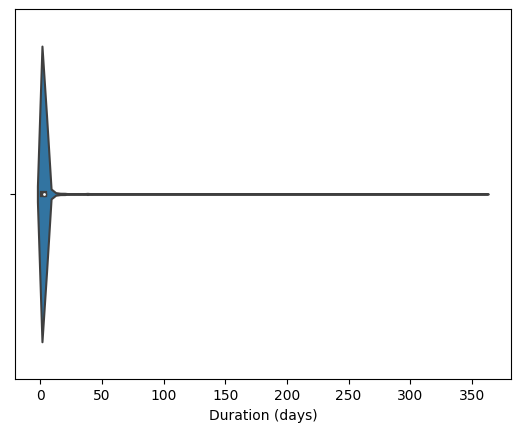

In [18]:
### Making a violin plot of the distribution of the duration of festivals

import seaborn as sns
import matplotlib.pyplot as plt

sns.violinplot(x=df_final['Duration (days)'])
plt.show()

## Objective 4: Export the data to Tableau and create visualizations for publication

With the data scraped, combined, and cleaned, we can now export it to Tableau and create visualizations for publication.

In [14]:
### Plotting a histogram of duration

df_final['Duration'].value_counts().plot(kind='bar')


KeyError: 'Duration'

In [ ]:
### 